In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta as ta
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


mm = MinMaxScaler()
ss = StandardScaler()

#https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#https://www.kaggle.com/code/iamleonie/time-series-forecasting-building-intuition/notebook?scriptVersionId=52169438

In [2]:
ticker = "USDJPY=X"
start=pd.to_datetime('2000-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')


#EURUSD = "EURUSD=X"
#USDJPY = "USDJPY=X"

#13 WEEK TREASURY BILL ="^IRX"
#Treasury Yield 5 Years ="^FVX"
#CBOE Interest Rate 10 Year= "^TNX"
#Treasury Yield 30 Years ="^TYX"

#S&P 500 = "^GSPC"
#Nikkei 225= "^N225"

#Crude Oil="CL=F"


In [3]:
# download daily stock price data by passing in specified ticker and date range

df = yf.download(ticker,start,end=today_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
#fig = go.Figure(data=go.Scatter(x=df.index,y=df['Close'],mode='lines'))
#fig.show()

In [5]:
#df

In [6]:
'''

#Download data for indicators available on Yahoo Finance

yahoo_indicators = ['USDJPY=X','^GSPC','^N225'] 
tickers = yf.Tickers(yahoo_indicators)
df = tickers.history(start=start,end=today_date,interval='1D',)
df

#https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance

'''

"\n\n#Download data for indicators available on Yahoo Finance\n\nyahoo_indicators = ['USDJPY=X','^GSPC','^N225'] \ntickers = yf.Tickers(yahoo_indicators)\ndf = tickers.history(start=start,end=today_date,interval='1D',)\ndf\n\n#https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance\n\n"

In [7]:
df.drop(columns=['Open','High','Low','Adj Close','Volume'],inplace=True)

In [8]:
#df= df.droplevel(0, axis=1)

In [9]:
#df.rename(columns={"USDJPY=X": "USDJPY", "^GSPC": "S&P", "^IRX": "US3M", "^N225": "Nikkei225"},inplace=True)
#df

In [10]:
df = df.rename_axis('Date').reset_index()

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
df.rename(columns={"Close": "USDJPY"},inplace=True)
#df.sort_values(by='Date', ascending=True,inplace=True)
df.set_index('Date',inplace=True)
df['returns'] = np.log(df['USDJPY'] / df['USDJPY'].shift(1))
print(df)

                USDJPY   returns
Date                            
2000-01-03  101.690002       NaN
2000-01-04  103.139999  0.014158
2000-01-05  104.089996  0.009169
2000-01-06  105.230003  0.010893
2000-01-07  105.330002  0.000950
...                ...       ...
2024-05-28  156.845001 -0.000159
2024-05-29  157.261993  0.002655
2024-05-30  157.608002  0.002198
2024-05-31  156.953003 -0.004165
2024-06-03  157.179993  0.001445

[6342 rows x 2 columns]


In [13]:
'''

#https://www.investing.com/rates-bonds/u.s.-2-year-bond-yield-historical-data

# Replace 'path/to/your/file.xlsx' with the actual path to your Excel file
USDJPY_file_path = '/Users/benny/Downloads/USD_JPY Historical Data.csv'

# Use pandas to read the Excel file
df = pd.read_csv(USDJPY_file_path)

# Print the dataframe to verify it was read correctly
#print(USDJPY_df)

df['Date'] = pd.to_datetime(df['Date'], format='mixed')

df.drop(['Open','High','Low','Change %','Vol.'], axis=1, inplace=True)
df.rename(columns={"Price": "USDJPY"},inplace=True)
df.sort_values(by='Date', ascending=True,inplace=True)
df.set_index('Date',inplace=True)
df['returns'] = np.log(df['USDJPY'] / df['USDJPY'].shift(1))
print(df)
'''


'\n\n#https://www.investing.com/rates-bonds/u.s.-2-year-bond-yield-historical-data\n\n# Replace \'path/to/your/file.xlsx\' with the actual path to your Excel file\nUSDJPY_file_path = \'/Users/benny/Downloads/USD_JPY Historical Data.csv\'\n\n# Use pandas to read the Excel file\ndf = pd.read_csv(USDJPY_file_path)\n\n# Print the dataframe to verify it was read correctly\n#print(USDJPY_df)\n\ndf[\'Date\'] = pd.to_datetime(df[\'Date\'], format=\'mixed\')\n\ndf.drop([\'Open\',\'High\',\'Low\',\'Change %\',\'Vol.\'], axis=1, inplace=True)\ndf.rename(columns={"Price": "USDJPY"},inplace=True)\ndf.sort_values(by=\'Date\', ascending=True,inplace=True)\ndf.set_index(\'Date\',inplace=True)\ndf[\'returns\'] = np.log(df[\'USDJPY\'] / df[\'USDJPY\'].shift(1))\nprint(df)\n'

In [14]:
df['change'] = ""

q1 = df['returns'].quantile(0.25)
q2 = df['returns'] .quantile(0.50)
q3 = df['returns'] .quantile(0.75)

for i in range(len(df['returns'])):
        if df['returns'][i] >= q3: 
            df['change'][i]= 1
        elif df['returns'][i] <= q1: 
            df['change'][i]= -1
        else :
            df['change'][i]= 0
            
df['change'] = df.change.astype(float)

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/353222998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'][i]= 0
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/353222998.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'][i]= 1
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/353222998.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'][i]= 1
/va

In [15]:
df['change']

Date
2000-01-03    0.0
2000-01-04    1.0
2000-01-05    1.0
2000-01-06    1.0
2000-01-07    0.0
             ... 
2024-05-28    0.0
2024-05-29    0.0
2024-05-30    0.0
2024-05-31   -1.0
2024-06-03    0.0
Name: change, Length: 6342, dtype: float64

In [16]:
window1 = 10
window2 = 20

df['MA1'] = df['USDJPY'].rolling(window1).mean()
df['MA2'] = df['USDJPY'].rolling(window2).mean()
df['MAposition'] = np.where(df['MA1'] > df['MA2'],1, -1)
df['MAsignal']=df['MA1'] - df['MA2']

In [17]:
# Calculate RSI
df["RSI"] =ta.momentum.RSIIndicator(df["USDJPY"],window=14, fillna= False).rsi()

In [18]:
#df['RSIposition'] = np.where(df['RSI'] > 70,1, 0)
df['RSIposition'] = np.nan
df['RSIposition'][df['RSI']> 70] = -1
df['RSIposition'][df['RSI'] < 30] = 1
df['RSIposition'][(df['RSI'] <= 70) & (df['RSI'] >= 30)] = 0

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/3762989194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSIposition'][df['RSI']> 70] = -1
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/3762989194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSIposition'][df['RSI'] < 30] = 1
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/3762989194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [19]:
# Calculate Bollinger Bands
bbands = ta.volatility.BollingerBands(df["USDJPY"],window=20, window_dev=1)
df["BB_upper"] = bbands.bollinger_hband()
df["BB_lower"] = bbands.bollinger_lband()

In [20]:
df['BBposition'] = np.nan
df['BBposition'][df["USDJPY"]>df["BB_upper"]] = -1
df['BBposition'][df["USDJPY"] < df["BB_lower"]] = 1
df['BBposition'][(df["USDJPY"] <= df["BB_upper"]) & (df["USDJPY"] >= df["BB_lower"])] = 0

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/1481601653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BBposition'][df["USDJPY"]>df["BB_upper"]] = -1
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/1481601653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BBposition'][df["USDJPY"] < df["BB_lower"]] = 1
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/1481601653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [21]:
# Calculate MACD
macd = ta.trend.MACD(df["USDJPY"],window_slow= 26, window_fast= 12, window_sign= 9)
df["MACD"] = macd.macd()
df["MACD_signal"] = macd.macd_signal()

In [22]:
df['MACDposition'] = np.where(df['MACD'] > df['MACD_signal'],1, -1)

In [23]:
df

USDJPY   returns  change         MA1         MA2  MAposition  \
Date                                                                           
2000-01-03  101.690002       NaN     0.0         NaN         NaN          -1   
2000-01-04  103.139999  0.014158     1.0         NaN         NaN          -1   
2000-01-05  104.089996  0.009169     1.0         NaN         NaN          -1   
2000-01-06  105.230003  0.010893     1.0         NaN         NaN          -1   
2000-01-07  105.330002  0.000950     0.0         NaN         NaN          -1   
...                ...       ...     ...         ...         ...         ...   
2024-05-28  156.845001 -0.000159     0.0  156.192599  155.690350           1   
2024-05-29  157.261993  0.002655     0.0  156.268999  155.667349           1   
2024-05-30  157.608002  0.002198     0.0  156.601599  155.762550           1   
2024-05-31  156.953003 -0.004165    -1.0  156.759000  155.957950           1   
2024-06-03  157.179993  0.001445     0.0  156.901599  156.138650           1   

            MAsignal        RSI  RSIposition    BB_upper    BB_lower  \
Date                                                                   
2000-01-03       NaN        NaN          NaN         NaN         NaN   
2000-01-04       NaN        NaN          NaN         NaN         NaN   
2000-01-05       NaN        NaN          NaN         NaN         NaN   
2000-01-06       NaN        NaN          NaN         NaN         NaN   
2000-01-07       NaN        NaN          NaN         NaN         NaN   
...              ...        ...          ...         ...         ...   
2024-05-28  0.502250  59.351573          0.0  156.874083  154.506617   
2024-05-29  0.601649  61.448305          0.0  156.815312  154.519387   
2024-05-30  0.839050  63.147000          0.0  156.986067  154.539032   
2024-05-31  0.801050  57.942184          0.0  157.035177  154.880723   
2024-06-03  0.762949  59.197323          0.0  157.095918  155.181382   

            BBposition      MACD  MACD_signal  MACDposition  
Date                                                         
2000-01-03         NaN       NaN          NaN            -1  
2000-01-04         NaN       NaN          NaN            -1  
2000-01-05         NaN       NaN          NaN            -1  
2000-01-06         NaN       NaN          NaN            -1  
2000-01-07         NaN       NaN          NaN            -1  
...                ...       ...          ...           ...  
2024-05-28         0.0  0.760494     0.737838             1  
2024-05-29        -1.0  0.786617     0.747594             1  
2024-05-30        -1.0  0.825721     0.763219             1  
2024-05-31         0.0  0.794698     0.769515             1  
2024-06-03        -1.0  0.779443     0.771500             1  

[6342 rows x 15 columns]

In [24]:
st = datetime(2007, 1, 1, 0, 0)

#df1=df[st:,['returns','MAposition','RSIposition','BBposition','MACDposition']]

df=df[st:]

df1=df[st:]

df1=df1.loc[:,['change','USDJPY','MAsignal','RSI','BB_upper','BB_lower','MACD','MACD_signal']]

In [25]:
df1

change      USDJPY  MAsignal        RSI    BB_upper    BB_lower  \
Date                                                                          
2007-01-01     0.0  118.879997  1.029749  62.836550  119.014074  116.349425   
2007-01-02     0.0  118.830002  0.917749  62.040812  119.071682  116.679818   
2007-01-03     1.0  119.339996  0.816749  66.676633  119.158628  116.994872   
2007-01-04    -1.0  118.830002  0.686249  58.926565  119.117733  117.404767   
2007-01-05     0.0  118.690002  0.536250  56.969002  119.112047  117.650453   
...            ...         ...       ...        ...         ...         ...   
2024-05-28     0.0  156.845001  0.502250  59.351573  156.874083  154.506617   
2024-05-29     0.0  157.261993  0.601649  61.448305  156.815312  154.519387   
2024-05-30     0.0  157.608002  0.839050  63.147000  156.986067  154.539032   
2024-05-31    -1.0  156.953003  0.801050  57.942184  157.035177  154.880723   
2024-06-03     0.0  157.179993  0.762949  59.197323  157.095918  155.181382   

                MACD  MACD_signal  
Date                               
2007-01-01  0.569965     0.425808  
2007-01-02  0.556380     0.451922  
2007-01-03  0.580079     0.477553  
2007-01-04  0.551352     0.492313  
2007-01-05  0.511394     0.496129  
...              ...          ...  
2024-05-28  0.760494     0.737838  
2024-05-29  0.786617     0.747594  
2024-05-30  0.825721     0.763219  
2024-05-31  0.794698     0.769515  
2024-06-03  0.779443     0.771500  

[4519 rows x 8 columns]

In [26]:
#df['MACDposition'][-360:].plot(figsize=(10, 6));

In [27]:
X, y = df1.drop(columns=['change']), df1['change'].values
X.shape, y.shape

((4519, 7), (4519,))

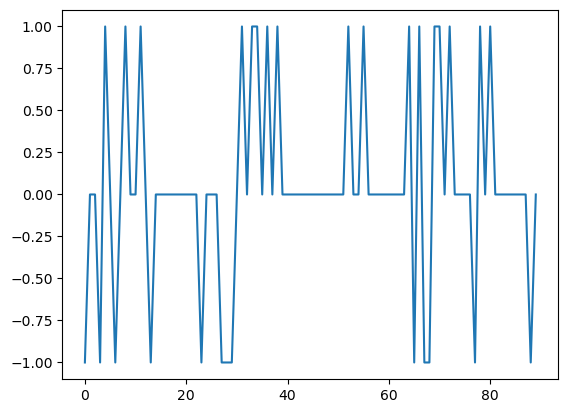

In [28]:
plt.plot(y[-90:], label='USDJPY_change')


In [29]:
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))
#y_trans = (y.reshape(-1, 1))

#https://www.analyticsvidhya.com/blog/2021/04/difference-between-fit-transform-fit_transform-methods-in-scikit-learn-with-python-code/
#https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape

In [30]:
X_trans

array([[0.62510004, 1.18165619, 0.9732106 , ..., 0.55538635, 0.67699489,
        0.51337281],
       [0.62226251, 1.04760531, 0.90559383, ..., 0.57449988, 0.65900217,
        0.54986733],
       [0.65120769, 0.92672063, 1.29951644, ..., 0.59272602, 0.69038861,
        0.58568669],
       ...,
       [2.82314126, 0.95341146, 0.99959061, ..., 2.7646895 , 1.01571534,
        0.98490047],
       [2.78596624, 0.90793035, 0.55731841, ..., 2.78445661, 0.97462824,
        0.99369863],
       [2.79884924, 0.8623287 , 0.66397213, ..., 2.80184999, 0.95442463,
        0.99647342]])

In [31]:
X_trans.shape, y_trans.shape

((4519, 7), (4519, 1))

In [32]:
print(y_trans)

[[ 0.]
 [ 0.]
 [ 1.]
 ...
 [ 0.]
 [-1.]
 [ 0.]]


In [33]:
#the window creates a lag in the output

output_length = 2
input_length = int(output_length*3)
window_length = 1

In [34]:
# split a multivariate sequence past, future samples (X and y)
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out, window):
    assert n_steps_out > window
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): 
            break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix,], output_sequence[end_ix-1+window:out_end_ix,-1]  #the window lags the start of the output sequence
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, input_length, output_length, window_length)
print(X_ss.shape, y_mm.shape)

(4513, 6, 7) (4513, 1)


In [35]:
X_ss[-1]

array([[2.7871016 , 0.30189024, 0.75186462, 2.73451736, 2.76041383,
        0.90547775, 0.93230082],
       [2.78125506, 0.50883126, 0.69239212, 2.72482484, 2.76245939,
        0.92675123, 0.94151503],
       [2.77983651, 0.55030274, 0.67707934, 2.72749075, 2.76281421,
        0.92932931, 0.94943047],
       [2.80350326, 0.66927209, 0.85524632, 2.72415485, 2.76355298,
        0.96392619, 0.96306409],
       [2.82314126, 0.95341146, 0.99959061, 2.73384711, 2.7646895 ,
        1.01571534, 0.98490047],
       [2.78596624, 0.90793035, 0.55731841, 2.73663465, 2.78445661,
        0.97462824, 0.99369863]])

In [36]:
y_mm[-1]

array([0.])

In [37]:
y_mm

array([[ 1.],
       [ 0.],
       [ 1.],
       ...,
       [ 0.],
       [-1.],
       [ 0.]])

In [38]:
assert y_mm[0].all() == y_trans[input_length-1:input_length-1+output_length].squeeze(1).all()

AssertionError: 

In [42]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (4067, 6, 7) (4067, 1)
Testing Shape: (446, 6, 7) (446, 1)


In [43]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [44]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], input_length, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], input_length, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([4067, 6, 7]) torch.Size([4067, 1])
Testing Shape: torch.Size([446, 6, 7]) torch.Size([446, 1])


In [45]:
#This doesnt seem to be used for anything

#X_check, y_check = split_sequences(X, y.reshape(-1, 1), input_length, output_length, window_length)
#X_check[-1][0:4]

In [46]:
#This doesnt seem to be used for anything

#df1['USDJPY_delta'].values[-output_length:]

In [47]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes  # output size
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)  # lstm
        # self.fc_1 = nn.Linear(hidden_size, 16)  # first fully connected layer
        # self.fc_2 = nn.Linear(128, 64)  # second fully connected layer
        # self.fc_3 = nn.Linear(32, 16)  # second fully connected layer
        self.fc_2 = nn.Linear(hidden_size, num_classes)  # third fully connected layer, adjusted to output size
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # (input, hidden, and cell state)
        hn = hn[-1,:,:]  # Get the last layer's output to feed to the dense layers
        out = self.relu(hn)
        # out = self.fc_1(out)  # first dense layer
        # out = self.relu(out)  # relu
        # out = self.dropout1(out)
        out = self.fc_2(out)  # second dense layer
        out = self.relu(out)  # relu
        # out = self.dropout1(out)
        # out = self.fc_3(out)  # second dense layer
        # out = self.relu(out)  # relu
        return out

In [48]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, checkpoint_filename='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.checkpoint_filename = checkpoint_filename

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.checkpoint_filename)  # Save your model
        self.val_loss_min = val_loss

In [49]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test, checkpoint_filename='checkpoint.pt'):
        # Initialize the early stopping object
        early_stopping = EarlyStopping(patience=10, verbose=False, checkpoint_filename=checkpoint_filename)

        for epoch in range(n_epochs):
            lstm.train()
            outputs = lstm.forward(X_train)  # forward pass
            optimiser.zero_grad()  # calculate the gradient, manually setting to 0
            loss = loss_fn(outputs, y_train)  # obtain the loss function
            loss.backward()  # calculates the loss of the loss function
            optimiser.step()  # improve from loss, i.e backprop

            # Evaluation with the test set
            lstm.eval()
            test_preds = lstm(X_test)
            test_loss = loss_fn(test_preds, y_test)

            if epoch % 100 == 0:
                print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))

            # Early stopping
            early_stopping(test_loss.item(), lstm)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        # Load the last checkpoint with the best model
        lstm.load_state_dict(torch.load(checkpoint_filename))

In [50]:
n_epochs = 2000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X.shape[1] # number of features
hidden_size = 8 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = output_length-window_length # number of output classes 

lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

/Users/benny/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [51]:
loss_fn = nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors, 
              checkpoint_filename='forex_checkpoint.pt')

Epoch: 0, train loss: 0.49029, test loss: 0.50224
Epoch: 100, train loss: 0.49029, test loss: 0.50224
Epoch: 200, train loss: 0.49029, test loss: 0.50224
Epoch: 300, train loss: 0.49029, test loss: 0.50224
Epoch: 400, train loss: 0.49029, test loss: 0.50224
Epoch: 500, train loss: 0.49029, test loss: 0.50224
Epoch: 600, train loss: 0.49029, test loss: 0.50224
Epoch: 700, train loss: 0.49029, test loss: 0.50224
Epoch: 800, train loss: 0.49029, test loss: 0.50224
Epoch: 900, train loss: 0.49029, test loss: 0.50224
Epoch: 1000, train loss: 0.49029, test loss: 0.50224
Epoch: 1100, train loss: 0.49029, test loss: 0.50224
Epoch: 1200, train loss: 0.49029, test loss: 0.50224
Epoch: 1300, train loss: 0.49029, test loss: 0.50224
Epoch: 1400, train loss: 0.49029, test loss: 0.50224
Epoch: 1500, train loss: 0.49029, test loss: 0.50224
Epoch: 1600, train loss: 0.49029, test loss: 0.50224
Epoch: 1700, train loss: 0.49029, test loss: 0.50224
Epoch: 1800, train loss: 0.49029, test loss: 0.50224
Epoch

In [52]:
lstm.load_state_dict(torch.load('forex_checkpoint.pt'))

<All keys matched successfully>

In [53]:
df_X_ss = ss.fit_transform(df1.drop(columns=['change'])) # old transformers
df_y_mm = mm.fit_transform(df1['change'].values.reshape(-1, 1)) # old transformers
#df_y_mm = df1['change'].values.reshape(-1, 1) # old transformers

In [54]:
df_y_mm.shape

(4519, 1)

In [55]:
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, input_length, output_length, window_length)

In [56]:
df_X_ss.shape

(4513, 6, 7)

In [57]:
df_y_mm.shape

(4513, 1)

In [58]:
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

In [59]:
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], input_length, df_X_ss.shape[2]))

In [63]:
train_predict = lstm(df_X_ss) # forward pass

data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

In [64]:
print(np.median(data_predict))

0.0


In [65]:
len(data_predict)

4513

In [66]:
data_predict2=np.zeros(shape=(len(data_predict), 1))

for i in range(len(data_predict)):
        if data_predict[i] >= 0: 
            data_predict2[i]= 1
        else :
            data_predict2[i]= 0

In [67]:
len(data_predict2)

4513

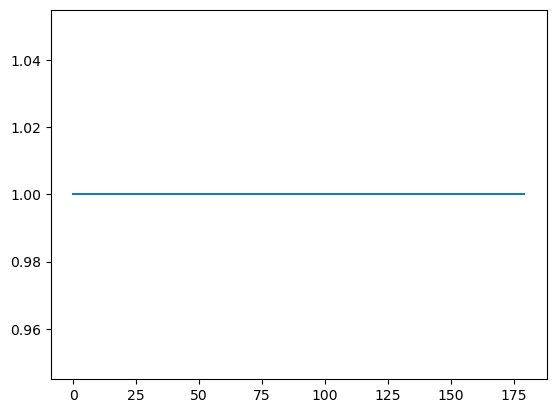

In [68]:
plt.plot(data_predict2[-180:])
plt.show()

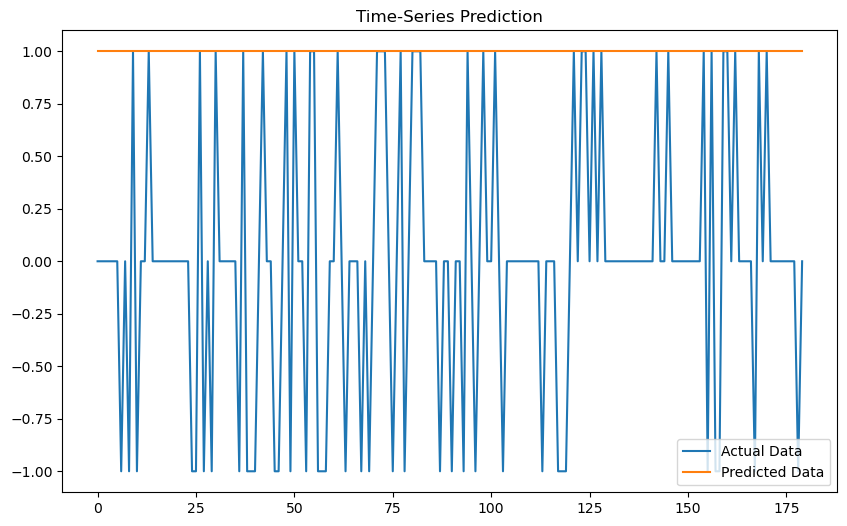

446


In [69]:
true, preds = [], []
for i in range(len(dataY_plot) - 180, len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(dataY_plot) - 180, len(data_predict2)):
    preds.append(data_predict2[i][0])
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 
print(len(dataY_plot)-train_test_cutoff)

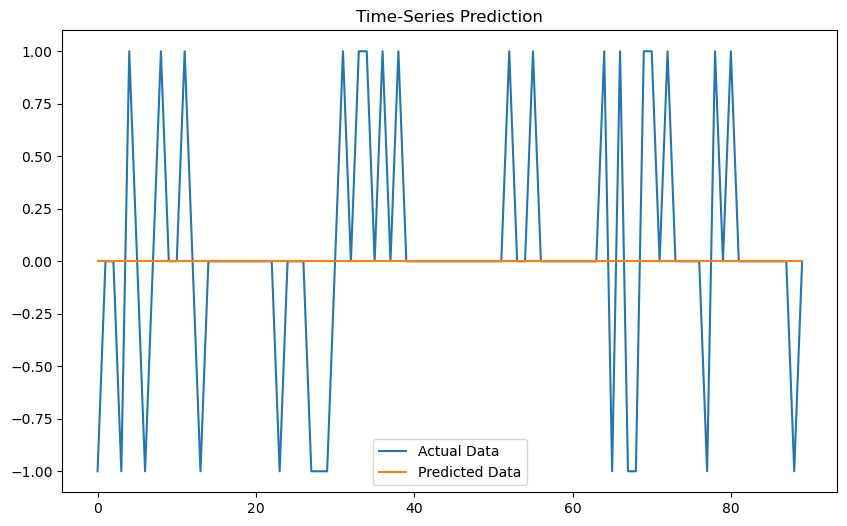

446


In [70]:
true, preds = [], []
for i in range(len(dataY_plot) - 90, len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(dataY_plot) - 90, len(data_predict)):
    preds.append(data_predict[i][0:18])
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 
print(len(dataY_plot)-train_test_cutoff)

In [71]:
df["signal"]= 0

for i in range(len(data_predict2)):
    df["signal"][i+input_length]=data_predict2[i][0]


/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/2415718540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["signal"]= 0
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/2415718540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["signal"][i+input_length]=data_predict2[i][0]
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/2415718540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [72]:
df["signal"]

Date
2007-01-01    0
2007-01-02    0
2007-01-03    0
2007-01-04    0
2007-01-05    0
             ..
2024-05-28    1
2024-05-29    1
2024-05-30    1
2024-05-31    1
2024-06-03    1
Name: signal, Length: 4519, dtype: int64

In [73]:
df['Technicalstrategy'] = df['signal'].shift(1) * df['returns']


/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_1934/4150566231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Technicalstrategy'] = df['signal'].shift(1) * df['returns']


In [74]:
df

USDJPY   returns  change         MA1         MA2  MAposition  \
Date                                                                           
2007-01-01  118.879997 -0.000841     0.0  118.711499  117.681750           1   
2007-01-02  118.830002 -0.000421     0.0  118.793499  117.875750           1   
2007-01-03  119.339996  0.004283     1.0  118.893499  118.076750           1   
2007-01-04  118.830002 -0.004283    -1.0  118.947499  118.261250           1   
2007-01-05  118.690002 -0.001179     0.0  118.917500  118.381250           1   
...                ...       ...     ...         ...         ...         ...   
2024-05-28  156.845001 -0.000159     0.0  156.192599  155.690350           1   
2024-05-29  157.261993  0.002655     0.0  156.268999  155.667349           1   
2024-05-30  157.608002  0.002198     0.0  156.601599  155.762550           1   
2024-05-31  156.953003 -0.004165    -1.0  156.759000  155.957950           1   
2024-06-03  157.179993  0.001445     0.0  156.901599  156.138650           1   

            MAsignal        RSI  RSIposition    BB_upper    BB_lower  \
Date                                                                   
2007-01-01  1.029749  62.836550          0.0  119.014074  116.349425   
2007-01-02  0.917749  62.040812          0.0  119.071682  116.679818   
2007-01-03  0.816749  66.676633          0.0  119.158628  116.994872   
2007-01-04  0.686249  58.926565          0.0  119.117733  117.404767   
2007-01-05  0.536250  56.969002          0.0  119.112047  117.650453   
...              ...        ...          ...         ...         ...   
2024-05-28  0.502250  59.351573          0.0  156.874083  154.506617   
2024-05-29  0.601649  61.448305          0.0  156.815312  154.519387   
2024-05-30  0.839050  63.147000          0.0  156.986067  154.539032   
2024-05-31  0.801050  57.942184          0.0  157.035177  154.880723   
2024-06-03  0.762949  59.197323          0.0  157.095918  155.181382   

            BBposition      MACD  MACD_signal  MACDposition  signal  \
Date                                                                  
2007-01-01         0.0  0.569965     0.425808             1       0   
2007-01-02         0.0  0.556380     0.451922             1       0   
2007-01-03        -1.0  0.580079     0.477553             1       0   
2007-01-04         0.0  0.551352     0.492313             1       0   
2007-01-05         0.0  0.511394     0.496129             1       0   
...                ...       ...          ...           ...     ...   
2024-05-28         0.0  0.760494     0.737838             1       1   
2024-05-29        -1.0  0.786617     0.747594             1       1   
2024-05-30        -1.0  0.825721     0.763219             1       1   
2024-05-31         0.0  0.794698     0.769515             1       1   
2024-06-03        -1.0  0.779443     0.771500             1       1   

            Technicalstrategy  
Date                           
2007-01-01                NaN  
2007-01-02          -0.000000  
2007-01-03           0.000000  
2007-01-04          -0.000000  
2007-01-05          -0.000000  
...                       ...  
2024-05-28          -0.000159  
2024-05-29           0.002655  
2024-05-30           0.002198  
2024-05-31          -0.004165  
2024-06-03           0.001445  

[4519 rows x 17 columns]

In [75]:
# terminal return of Technicalstrategy
np.exp(df['Technicalstrategy']).cumprod()[-1] -1

# calculate annualized return of Technicalstrategy
annualized_return_Technicalstrategy = np.exp(df['Technicalstrategy']).prod()**(252/df.shape[0])-1
annualized_return_Technicalstrategy

# calculate annualized volatility of Technicalstrategy
annualized_vol_Technicalstrategy = (np.exp(df['Technicalstrategy'])-1).std()*(252**0.5)
annualized_vol_Technicalstrategy

riskfree_rate = 0.0
# calculate Sharpe ratio of Technicalstrategy
sharpe_ratio_Technicalstrategy =(annualized_return_Technicalstrategy - riskfree_rate) /annualized_vol_Technicalstrategy
sharpe_ratio_Technicalstrategy

0.12844886126841093

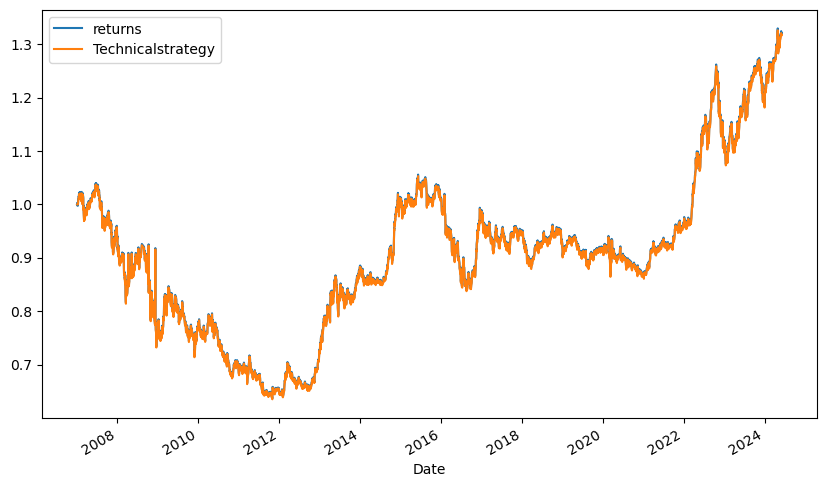

In [76]:
df[['returns', 'Technicalstrategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
df['USDJPY'].plot(figsize=(10, 6));